
# Lab: IoT Multi‑Sensor Forecasting with (Updated)
**Update:** แก้ปัญหา `ValueError: could not convert string to float: 'dev_00'` โดยเพิ่มการเข้ารหัส `device_id` ผ่าน `OneHotEncoder` ภายใน `ColumnTransformer` ในทุกส่วนที่เทรนโมเดล


## 0) Setup

In [1]:

# Core
import numpy as np
import pandas as pd

# Modeling
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Metrics & Viz
import matplotlib.pyplot as plt

RNG = np.random.RandomState(7)

def mae_score(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))



## 1) Simulate IoT Multi‑Sensor Panel Data
จำลองหลายอุปกรณ์ (`device_id`) และเซนเซอร์ต่าง ๆ เพื่อพยากรณ์พลังงานชั่วโมงถัดไป


In [2]:

# Config
N_DEVICES = 5
N_HOURS   = 24*30  # 30 days hourly
dates = pd.date_range('2025-01-01', periods=N_HOURS, freq='H')

rows = []
for dev in range(N_DEVICES):
    temp_base = 24 + RNG.normal(0, 0.4)
    vib_base = 0.6 + 0.1*dev
    volt_base = 220 + RNG.normal(0, 1.0)
    for t, ts in enumerate(dates):
        diurnal = 2*np.sin(2*np.pi*(t % 24)/24)
        temp = temp_base + 5*np.sin(2*np.pi*(t-6)/24) + RNG.normal(0, 0.6)
        humidity = 55 + 10*np.sin(2*np.pi*(t)/24 + 1.2) + RNG.normal(0, 2.0)
        vibration = vib_base + 0.05*np.sin(2*np.pi*(t)/168) + RNG.normal(0, 0.03)
        current = 4 + 0.8*np.sin(2*np.pi*(t)/24) + 0.02*temp + RNG.normal(0, 0.2)
        voltage = volt_base + 1.5*np.sin(2*np.pi*(t)/24 + 0.5) + RNG.normal(0, 0.8)
        power = voltage*current/100.0 + 0.3*vibration + 0.02*(humidity-50) + 0.1*diurnal + RNG.normal(0, 0.3)
        rows.append([ts, f"dev_{dev:02d}", temp, humidity, vibration, current, voltage, power])

df_raw = pd.DataFrame(rows, columns=['timestamp','device_id','temp','humidity','vibration','current','voltage','power']).set_index('timestamp').sort_index()
df_raw.head()


/tmp/ipykernel_2692/3952055142.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range('2025-01-01', periods=N_HOURS, freq='H')


,device_id,temp,humidity,vibration,current,voltage,power
timestamp,,,,,,,
2025-01-01,dev_00,19.695902,65.135423,0.576332,4.394331,220.252489,9.627815
2025-01-01,dev_02,18.563875,65.117153,0.799659,4.265953,220.410124,10.079983
2025-01-01,dev_04,19.502225,66.298822,1.020651,4.660758,221.912280,10.667554
2025-01-01,dev_01,17.882755,69.832868,0.689456,4.316905,218.411636,9.877032
2025-01-01,dev_03,18.145040,62.659928,0.866858,4.408727,220.423388,10.242830



## 2) Feature Engineering — Per‑Device Lags & Rolling
สร้าง `power_next` และ lag/rolling ต่ออุปกรณ์


In [3]:

SENSOR_COLS = ['temp','humidity','vibration','current','voltage','power']

def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['dow_sin']  = np.sin(2*np.pi*df['dayofweek']/7)
    df['dow_cos']  = np.cos(2*np.pi*df['dayofweek']/7)
    return df

def panel_lag_roll(df, group_col='device_id', sensors=SENSOR_COLS, lags=(1,2,3,6,12,24), rolls=(3,6,12,24)):
    df = df.copy()
    df = add_time_features(df)
    df['power_next'] = df.groupby(group_col)['power'].shift(-1)
    for col in sensors:
        for L in lags:
            df[f'{col}_lag{L}'] = df.groupby(group_col)[col].shift(L)
    for col in sensors:
        for W in rolls:
            df[f'{col}_rmean{W}'] = df.groupby(group_col)[col].shift(1).rolling(W).mean()
            df[f'{col}_rstd{W}']  = df.groupby(group_col)[col].shift(1).rolling(W).std()
    df = df.dropna().copy()
    return df

df_feat = panel_lag_roll(df_raw)
df_feat.head()


,device_id,temp,humidity,vibration,current,voltage,power,hour,dayofweek,hour_sin,...,voltage_rmean24,voltage_rstd24,power_rmean3,power_rstd3,power_rmean6,power_rstd6,power_rmean12,power_rstd12,power_rmean24,power_rstd24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-02,dev_00,19.512181,62.673471,0.630658,4.083023,220.264792,8.898035,0,3,0.0,...,218.806357,1.524297,9.163497,0.832708,9.013843,0.740150,8.834581,0.568444,8.709856,0.575622
2025-01-02,dev_04,19.407638,63.920605,1.066920,4.283930,221.808656,10.185964,0,3,0.0,...,218.872193,1.601053,9.394016,0.615160,8.958098,0.707779,8.862063,0.576605,8.745242,0.576704
2025-01-02,dev_02,18.889332,65.426770,0.862365,3.901766,220.550302,8.829731,0,3,0.0,...,219.050848,1.475593,9.045630,0.123041,9.133134,0.529181,8.922167,0.552457,8.775358,0.572500
2025-01-02,dev_01,18.748761,65.683507,0.735815,4.519137,217.437682,10.296476,0,3,0.0,...,219.056121,1.471693,9.164730,0.117791,9.164114,0.531894,9.001971,0.526541,8.846721,0.519717
2025-01-02,dev_03,19.451986,62.491533,0.961019,4.196043,220.879758,9.964823,0,3,0.0,...,219.198838,1.542974,9.188352,0.125921,9.291184,0.412796,9.055244,0.514447,8.872510,0.523372



## 3) Prepare X, y และ Preprocessing (ColumnTransformer)
เข้ารหัส `device_id` ด้วย OneHotEncoder และสเกลคอลัมน์ตัวเลขด้วย StandardScaler ภายใน pipeline


In [4]:

TARGET = 'power_next'
Y = df_feat[TARGET].copy()
X = df_feat.drop(columns=[TARGET]).copy()

# identify numeric and categorical columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()  # includes 'device_id'

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

X.shape, Y.shape, len(num_cols), len(cat_cols)


((3475, 97), (3475,), 96, 1)

In [5]:
X

,device_id,temp,humidity,vibration,current,voltage,power,hour,dayofweek,hour_sin,...,voltage_rmean24,voltage_rstd24,power_rmean3,power_rstd3,power_rmean6,power_rstd6,power_rmean12,power_rstd12,power_rmean24,power_rstd24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-02 00:00:00,dev_00,19.512181,62.673471,0.630658,4.083023,220.264792,8.898035,0,3,0.0,...,218.806357,1.524297,9.163497,0.832708,9.013843,0.740150,8.834581,0.568444,8.709856,0.575622
2025-01-02 00:00:00,dev_04,19.407638,63.920605,1.066920,4.283930,221.808656,10.185964,0,3,0.0,...,218.872193,1.601053,9.394016,0.615160,8.958098,0.707779,8.862063,0.576605,8.745242,0.576704
2025-01-02 00:00:00,dev_02,18.889332,65.426770,0.862365,3.901766,220.550302,8.829731,0,3,0.0,...,219.050848,1.475593,9.045630,0.123041,9.133134,0.529181,8.922167,0.552457,8.775358,0.572500
2025-01-02 00:00:00,dev_01,18.748761,65.683507,0.735815,4.519137,217.437682,10.296476,0,3,0.0,...,219.056121,1.471693,9.164730,0.117791,9.164114,0.531894,9.001971,0.526541,8.846721,0.519717
2025-01-02 00:00:00,dev_03,19.451986,62.491533,0.961019,4.196043,220.879758,9.964823,0,3,0.0,...,219.198838,1.542974,9.188352,0.125921,9.291184,0.412796,9.055244,0.514447,8.872510,0.523372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30 22:00:00,dev_01,19.523426,64.195892,0.763586,3.997826,217.530856,9.516317,22,3,-0.5,...,218.190252,1.606676,8.587885,0.640241,8.265239,0.609766,8.443603,0.559395,8.282238,0.623241
2025-01-30 22:00:00,dev_03,19.818381,62.298335,1.047647,4.254619,219.911218,9.774642,22,3,-0.5,...,218.404045,1.485145,8.833950,0.867140,8.500904,0.792581,8.550381,0.638306,8.342195,0.672644
2025-01-30 22:00:00,dev_02,19.611172,59.345896,0.821620,3.835563,220.911822,9.111753,22,3,-0.5,...,218.526273,1.486050,8.773418,0.846289,8.606700,0.798714,8.611011,0.634685,8.371725,0.681668


In [6]:
Y

timestamp
2025-01-02 00:00:00    11.652556
2025-01-02 00:00:00    10.483496
2025-01-02 00:00:00    11.222062
2025-01-02 00:00:00    10.578411
2025-01-02 00:00:00     9.999810
                         ...    
2025-01-30 22:00:00     8.817260
2025-01-30 22:00:00     9.642260
2025-01-30 22:00:00     9.961063
2025-01-30 22:00:00     8.893890
2025-01-30 22:00:00    10.453605
Name: power_next, Length: 3475, dtype: float64


## 4) Visualize TimeSeriesSplit (Expanding vs Rolling)


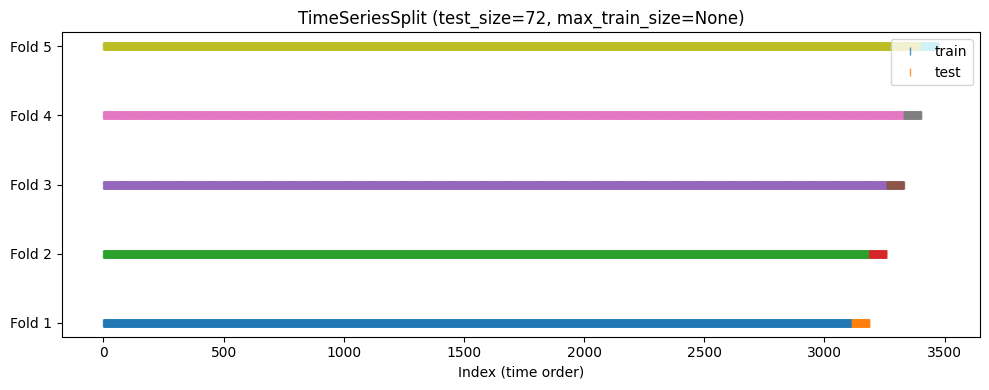

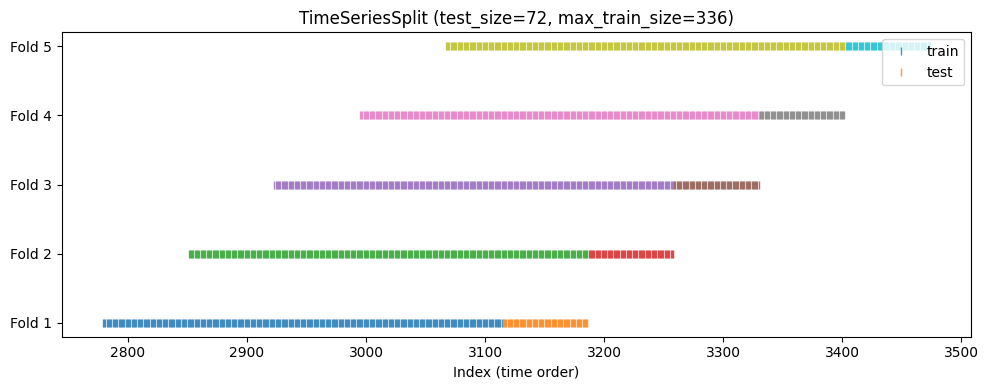

In [7]:

def show_tscv_indices(n_splits=5, test_size=24*3, max_train_size=None):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, max_train_size=max_train_size)
    n = len(X)
    fig, ax = plt.subplots(figsize=(10, 2 + 0.4*n_splits))
    for i, (tr, te) in enumerate(tscv.split(np.arange(n)), 1):
        ax.plot(tr, [i]*len(tr), marker='|', linestyle='None', label='train' if i==1 else "", alpha=0.8)
        ax.plot(te, [i]*len(te), marker='|', linestyle='None', label='test' if i==1 else "", alpha=0.8)
    ax.set_yticks(range(1, n_splits+1))
    ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits+1)])
    ax.set_xlabel('Index (time order)'); ax.legend(loc='upper right')
    ax.set_title(f'TimeSeriesSplit (test_size={test_size}, max_train_size={max_train_size})')
    plt.tight_layout(); plt.show()

show_tscv_indices(n_splits=5, test_size=24*3, max_train_size=None)    # Expanding
show_tscv_indices(n_splits=5, test_size=24*3, max_train_size=24*14)   # Rolling



## 5) Train Baselines (Ridge vs RandomForest) with Expanding TSCV + Preprocessing


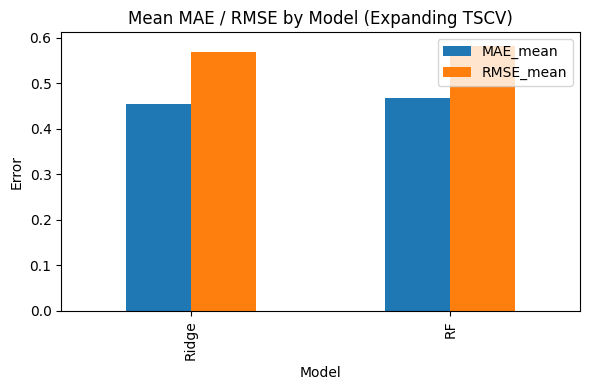

,MAE_mean,RMSE_mean
model,,
Ridge,0.453156,0.568329
RF,0.466836,0.582331


In [8]:

tscv = TimeSeriesSplit(n_splits=5, test_size=24*3)

models = {
    'Ridge': Pipeline([('prep', preprocess), ('model', Ridge(alpha=1.0, random_state=7))]),
    'RF':    Pipeline([('prep', preprocess), ('model', RandomForestRegressor(n_estimators=400, random_state=7, n_jobs=-1))])
}

scores = []
for name, mdl in models.items():
    fold_mae, fold_rmse = [], []
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        mdl.fit(Xtr, Ytr)
        yhat = mdl.predict(Xte)
        fold_mae.append(mae_score(Yte, yhat))
        fold_rmse.append(rmse_score(Yte, yhat))
    scores.append({'model': name, 'MAE_mean': np.mean(fold_mae), 'RMSE_mean': np.mean(fold_rmse)})

scores_df = pd.DataFrame(scores).set_index('model')
ax = scores_df[['MAE_mean','RMSE_mean']].plot(kind='bar', figsize=(6,4))
ax.set_title('Mean MAE / RMSE by Model (Expanding TSCV)')
ax.set_ylabel('Error'); ax.set_xlabel('Model')
plt.tight_layout(); plt.show()

scores_df



## 6) Plot Predictions vs Ground Truth (Last Fold, per Device)


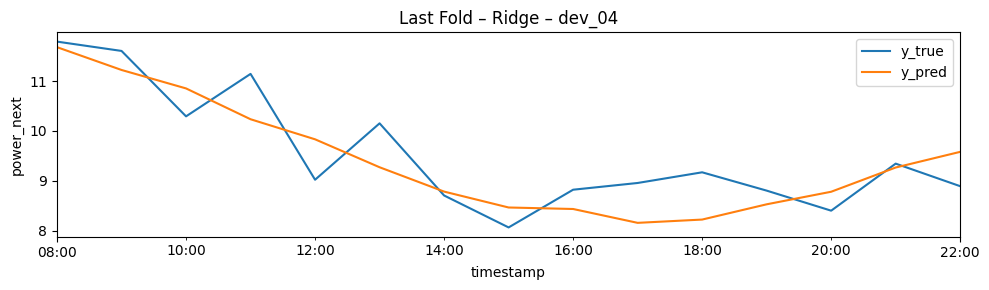

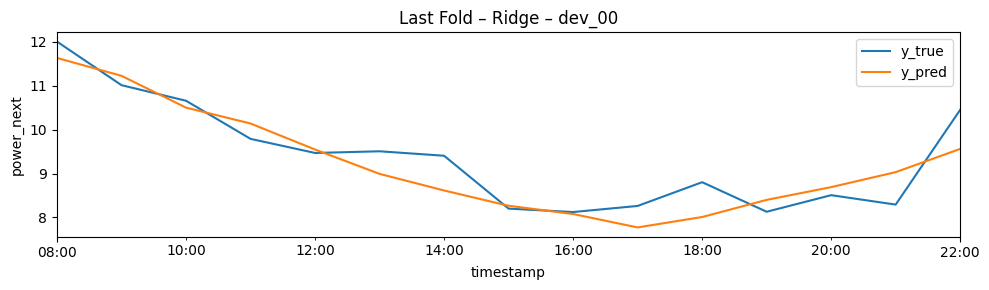

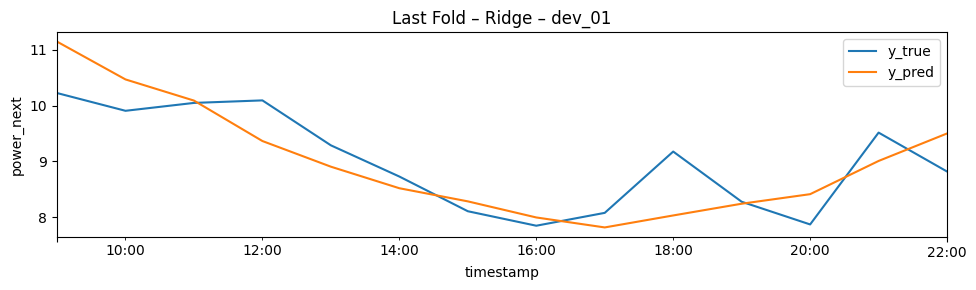

In [9]:

best_name = scores_df['RMSE_mean'].idxmin()
best_model = models[best_name]

for i, (tr, te) in enumerate(tscv.split(X), 1):
    pass
for i, (tr, te) in enumerate(tscv.split(X), 1):
    last_tr, last_te = tr, te

best_model.fit(X.iloc[last_tr], Y.iloc[last_tr])
yhat_last = best_model.predict(X.iloc[last_te])

vis_df = pd.DataFrame({'y_true': Y.iloc[last_te].values, 'y_pred': yhat_last}, index=Y.iloc[last_te].index)
vis_df['device_id'] = df_feat.iloc[last_te]['device_id'].values

for dev in vis_df['device_id'].unique()[:3]:
    sub = vis_df[vis_df['device_id']==dev][['y_true','y_pred']]
    ax = sub.plot(figsize=(10,3))
    ax.set_title(f'Last Fold – {best_name} – {dev}')
    ax.set_ylabel('power_next')
    plt.tight_layout(); plt.show()



## 7) Multi‑Step Forecasting (H‑step) with Proper Encoding
สร้างเมทริกซ์ `power_lead1..power_leadH` และใช้ **Direct** + **MultiOutput** โดยมี `ColumnTransformer` เข้ารหัสหมวดหมู่


In [10]:

def build_panel_supervised(df, H=6, group_col='device_id'):
    df = df.copy()
    for h in range(1, H+1):
        df[f'power_lead{h}'] = df.groupby(group_col)['power'].shift(-h)
    df2 = df.dropna().copy()
    feature_cols = [c for c in df2.columns if not c.startswith('power_lead') and c != 'power_next']
    XH = df2[feature_cols]
    YH = df2[[f'power_lead{h}' for h in range(1, H+1)]]
    return XH, YH

H = 6
XH, YH = build_panel_supervised(df_feat, H=H)

# Build preprocess for XH
num_cols_H = XH.select_dtypes(include=['number']).columns.tolist()
cat_cols_H = XH.select_dtypes(include=['object','category']).columns.tolist()

preprocess_H = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_H),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_H)
    ],
    remainder='drop'
)

XH.shape, YH.shape, len(num_cols_H), len(cat_cols_H)


((3445, 97), (3445, 6), 96, 1)

In [11]:

# 7.1 Direct strategy (Ridge base) + preprocessing
def tscv_direct_with_prep(X, Y, base_estimator, preprocess, tscv):
    H = Y.shape[1]
    mae_h, rmse_h = [[] for _ in range(H)], [[] for _ in range(H)]
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        preds = np.zeros_like(Yte.values, dtype=float)
        for h in range(H):
            pipe = Pipeline([('prep', preprocess), ('model', base_estimator)])
            pipe.fit(Xtr, Ytr.iloc[:,h])
            preds[:,h] = pipe.predict(Xte)
        for h in range(H):
            mae_h[h].append(mae_score(Yte.iloc[:,h], preds[:,h]))
            rmse_h[h].append(rmse_score(Yte.iloc[:,h], preds[:,h]))
    return [np.mean(m) for m in mae_h], [np.mean(m) for m in rmse_h]

tscv_H = TimeSeriesSplit(n_splits=5, test_size=24*3)
mae_dir, rmse_dir = tscv_direct_with_prep(XH, YH, Ridge(random_state=7), preprocess_H, tscv_H)
pd.DataFrame({'h': np.arange(1, H+1), 'MAE': mae_dir, 'RMSE': rmse_dir})


,h,MAE,RMSE
0,1,0.443876,0.553898
1,2,0.443265,0.556699
2,3,0.451660,0.563368
3,4,0.450363,0.560973
4,5,0.446409,0.557653
5,6,0.450285,0.561292


In [12]:

# 7.2 MultiOutput strategy (RF inside MultiOutputRegressor) + preprocessing
def tscv_multioutput_with_prep(X, Y, base_estimator, preprocess, tscv):
    H = Y.shape[1]
    mae_h, rmse_h = [[] for _ in range(H)], [[] for _ in range(H)]
    model = Pipeline([('prep', preprocess), ('mo', MultiOutputRegressor(base_estimator))])
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        model.fit(Xtr, Ytr)
        preds = model.predict(Xte)
        for h in range(H):
            mae_h[h].append(mae_score(Yte.iloc[:,h], preds[:,h]))
            rmse_h[h].append(rmse_score(Yte.iloc[:,h], preds[:,h]))
    return [np.mean(m) for m in mae_h], [np.mean(m) for m in rmse_h]

mae_mo, rmse_mo = tscv_multioutput_with_prep(
    XH, YH, RandomForestRegressor(n_estimators=300, random_state=7, n_jobs=-1), preprocess_H, tscv_H
)
pd.DataFrame({'h': np.arange(1, H+1), 'MAE': mae_mo, 'RMSE': rmse_mo})


,h,MAE,RMSE
0,1,0.454144,0.567729
1,2,0.446016,0.563018
2,3,0.448378,0.564823
3,4,0.459233,0.572623
4,5,0.458463,0.575460
5,6,0.453273,0.569115


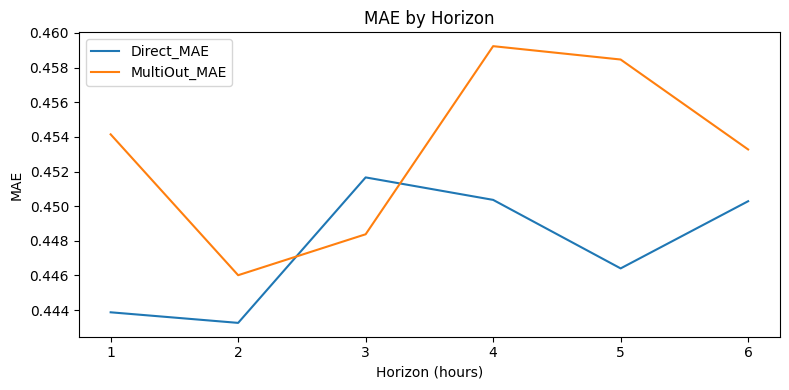

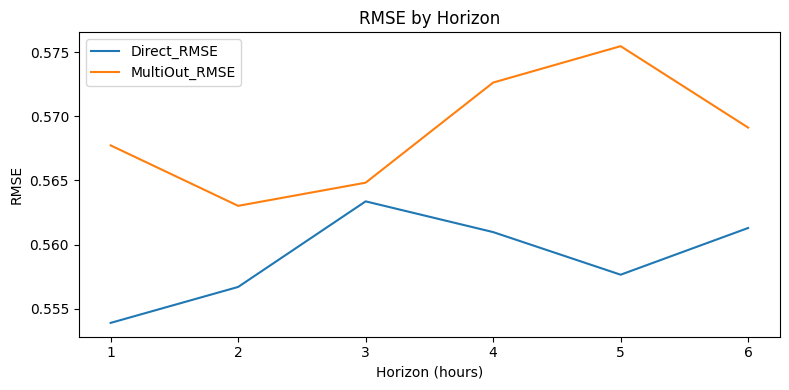

,Direct_MAE,MultiOut_MAE,Direct_RMSE,MultiOut_RMSE
h,,,,
1,0.443876,0.454144,0.553898,0.567729
2,0.443265,0.446016,0.556699,0.563018
3,0.451660,0.448378,0.563368,0.564823
4,0.450363,0.459233,0.560973,0.572623
5,0.446409,0.458463,0.557653,0.575460
6,0.450285,0.453273,0.561292,0.569115


In [13]:

# Compare MAE & RMSE by horizon
cmp = pd.DataFrame({
    'h': np.arange(1, H+1),
    'Direct_MAE': mae_dir, 'MultiOut_MAE': mae_mo,
    'Direct_RMSE': rmse_dir, 'MultiOut_RMSE': rmse_mo
}).set_index('h')

ax = cmp[['Direct_MAE','MultiOut_MAE']].plot(figsize=(8,4))
ax.set_title('MAE by Horizon'); ax.set_xlabel('Horizon (hours)'); ax.set_ylabel('MAE')
plt.tight_layout(); plt.show()

ax = cmp[['Direct_RMSE','MultiOut_RMSE']].plot(figsize=(8,4))
ax.set_title('RMSE by Horizon'); ax.set_xlabel('Horizon (hours)'); ax.set_ylabel('RMSE')
plt.tight_layout(); plt.show()

cmp



## 8) (Optional) Nested GridSearchCV (No Temporal Leakage)
ปรับใช้ `preprocess` ใน pipeline เพื่อจูนโดยไม่รั่วข้อมูลเวลา


In [14]:

outer = TimeSeriesSplit(n_splits=4, test_size=24*3)
inner = TimeSeriesSplit(n_splits=3, test_size=24)

ridge_pipe = Pipeline([('prep', preprocess), ('model', Ridge(random_state=7))])
ridge_grid = {'model__alpha': [0.1, 0.3, 1.0, 3.0, 10.0]}

outer_res = []
for i, (tr, te) in enumerate(outer.split(X), 1):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    Ytr, Yte = Y.iloc[tr], Y.iloc[te]
    gs = GridSearchCV(ridge_pipe, ridge_grid, scoring='neg_root_mean_squared_error', cv=inner, n_jobs=-1, return_train_score=True)
    gs.fit(Xtr, Ytr)
    yhat = gs.best_estimator_.predict(Xte)
    outer_res.append({'fold': i, 'alpha': gs.best_params_['model__alpha'], 'MAE': mae_score(Yte,yhat), 'RMSE': rmse_score(Yte,yhat)})

pd.DataFrame(outer_res)


,fold,alpha,MAE,RMSE
0,1,0.1,0.449238,0.570946
1,2,1.0,0.467924,0.566290
2,3,10.0,0.452744,0.559172
3,4,0.1,0.460108,0.581184



## 9) (Optional) ใช้ **CSV จริงของคุณ**
โหลด CSV ที่มี `timestamp`, `device_id`, sensor ต่าง ๆ และ `power` แล้วรัน pipeline เดิม (มี preprocess รองรับ categorical)


In [15]:

USE_REAL = False
CSV_PATH = "iot_sensors.csv"
TIMECOL  = "timestamp"
DEVICECOL= "device_id"
TARGET_POWER_COL = "power"    # เปลี่ยนชื่อ target ได้

if USE_REAL:
    df_real = pd.read_csv(CSV_PATH)
    df_real[TIMECOL] = pd.to_datetime(df_real[TIMECOL], errors='coerce')
    df_real = df_real.dropna(subset=[TIMECOL, DEVICECOL, TARGET_POWER_COL]).set_index(TIMECOL).sort_index()
    df_raw = df_real.rename(columns={TARGET_POWER_COL:'power'})
    df_feat = panel_lag_roll(df_raw)
    TARGET = 'power_next'
    Y = df_feat[TARGET].copy()
    X = df_feat.drop(columns=[TARGET]).copy()
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
    preprocess = ColumnTransformer([('num', StandardScaler(), num_cols),
                                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)], remainder='drop')
    print("Loaded real CSV. Shapes:", X.shape, Y.shape, "Num cols:", len(num_cols), "Cat cols:", len(cat_cols))
else:
    print("Using simulated data. Set USE_REAL=True to switch.")


Using simulated data. Set USE_REAL=True to switch.



## 10) Deployment Notes (IoT Edge/Cloud)
- ใช้ **ColumnTransformer** ใน pipeline เสมอสำหรับฟีเจอร์ผสมเชิงตัวเลข/หมวดหมู่ เพื่อป้องกัน error และ leakage
- ปรับ **rolling window** ตาม concept drift ของเครื่องจักร
- ถ้ามี **exogenous อนาคต** (ตารางปฏิบัติงาน/กำลังไฟ) ให้ป้อนเป็นฟีเจอร์ตอนอนุมานเพื่อความแม่นยำ
